<a href="https://colab.research.google.com/github/Houdayfahousny/CancerClassification/blob/main/Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files  # Importe la fonction d'upload
files.upload()  # Lance l'interface d'upload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"houdayfahousny","key":"93738ef2946776c7b409823abcdfd4f1"}'}

In [ ]:
!mkdir -p ~/.kaggle  # Crée un dossier caché pour Kaggle
!mv kaggle.json ~/.kaggle/  # Déplace le fichier
!chmod 600 ~/.kaggle/kaggle.json  # Sécurise les permissions

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  # Télécharge le dataset
!unzip skin-cancer-mnist-ham10000.zip  # Dézippe le fichier

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import os
images_part1 = os.listdir('/content/HAM10000_images_part_1')
images_part2 = os.listdir('/content/HAM10000_images_part_2')
print(f"Nombre d'images dans part_1 : {len(images_part1)}")
print(f"Nombre d'images dans part_2 : {len(images_part2)}")

Nombre d'images dans part_1 : 5000
Nombre d'images dans part_2 : 5015


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/HAM10000_metadata.csv')
metadata.head()  # Afficher les 5 premières lignes

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(1)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization


from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
base_skin_dir = os.path.join('..', 'input')

base_dir = '/content/'
print("Contenu du répertoire :", os.listdir(base_dir))

# 2. Création du dictionnaire des chemins (version robuste)
image_paths = []
for dir_name in ['HAM10000_images_part_1', 'HAM10000_images_part_2',
                 'ham10000_images_part_1', 'ham10000_images_part_2']:
    if os.path.exists(os.path.join(base_dir, dir_name)):
        image_paths.extend(glob(os.path.join(base_dir, dir_name, '*.jpg')))

imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in image_paths
}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
# 3. Chargement des métadonnées
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
skin_df = pd.read_csv(metadata_path)

skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# 4. Mapping des chemins avec vérification
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict)



Contenu du répertoire : ['.config', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'HAM10000_metadata.csv', 'HAM10000_images_part_1', 'skin-cancer-mnist-ham10000.zip', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv', 'ham10000_images_part_2', 'sample_data']


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,/content/ham10000_images_part_2/ISIC_0031633.jpg


In [ ]:
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
cell_type,0
cell_type_idx,0
path,0


In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

<ipython-input-10-8b8ec19cc3cf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0027419.jpg,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0025030.jpg,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0026769.jpg,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,/content/ham10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,/content/ham10000_images_part_2/ISIC_0031633.jpg,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


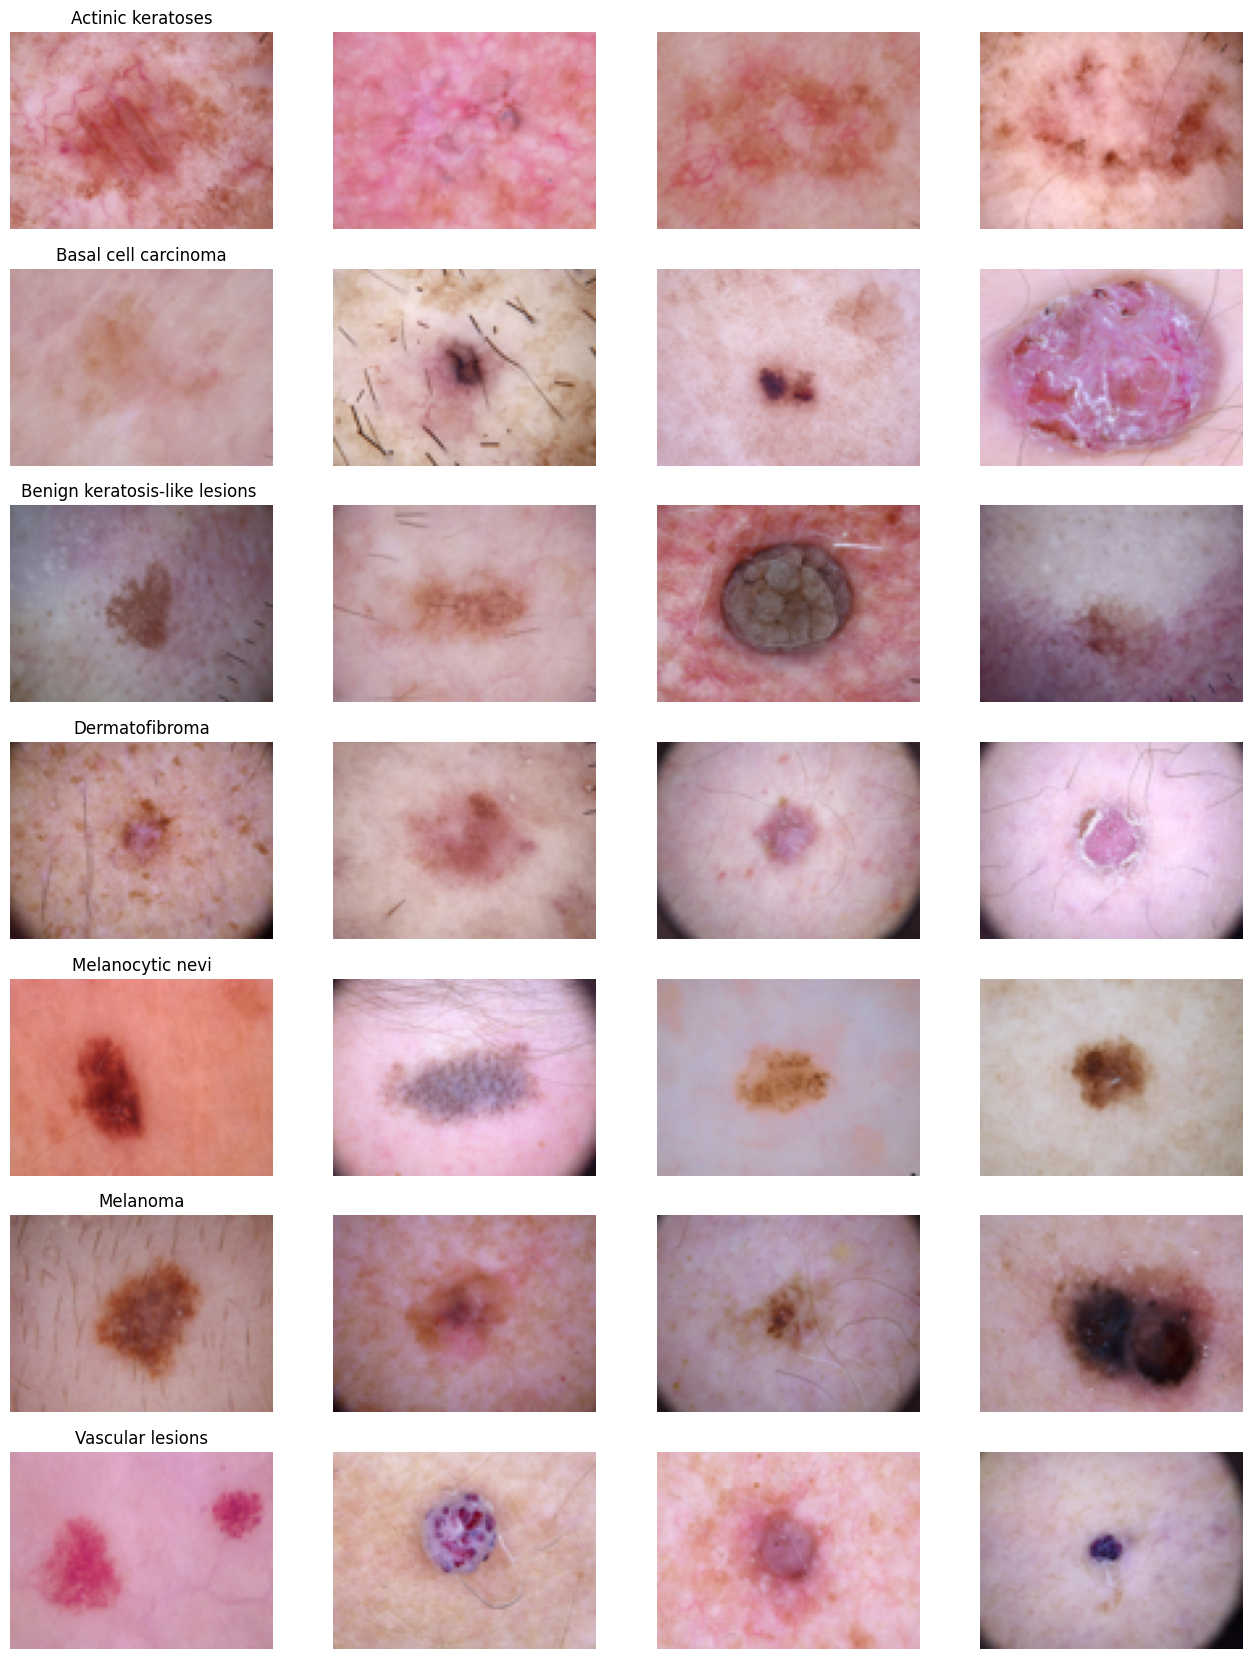

In [ ]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.optimizers import Adam

In [ ]:
from keras.callbacks import ReduceLROnPlateau

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [ ]:
from tensorflow.keras.optimizers import Adam


optimizer = Adam(learning_rate=0.01)


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 10

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_validate, y_validate),
    verbose=1,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 293s 403ms/step - accuracy: 0.6578 - loss: 1.1208 - val_accuracy: 0.6808 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 290s 402ms/step - accuracy: 0.6618 - loss: 0.9307 - val_accuracy: 0.6933 - val_loss: 0.8302 - learning_rate: 0.0010
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 338s 424ms/step - accuracy: 0.6924 - loss: 0.8560 - val_accuracy: 0.6920 - val_loss: 0.8399 - learning_rate: 0.0010
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 304s 422ms/step - accuracy: 0.6943 - loss: 0.8263 - val_accuracy: 0.7132 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 315s 413ms/step - accuracy: 0.7106 - loss: 0.8065 - val_accuracy: 0.7070 - val_loss: 0.8169 - learning_rate: 0.0010
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 282s 391ms/step - accuracy: 0.7179 - loss: 0.7692 - val_accuracy: 0.7357 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 290s 402ms/step - accura

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.7371 - loss: 0.7456
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.7724 - loss: 0.7189
Validation: accuracy = 0.745636  ;  loss_v = 0.751644
Test: accuracy = 0.721917  ;  loss = 0.770962
